# Assignment 1 - Image Fundamentals

Class: COMP 5970 - Computer Vision

Author: Chris Hinkson

Email: cmh0201@auburn.edu

*Personal Contribution Statement: This was an individual project and I did everything in it.*

## Task 1 Report: Photometric Decoder

The goal of Task 1 is to build a Photometric Decoder that reveals a hidden phrase or message in a provided photograph. For full details, see [Assignment1.pdf](../Assignment1.pdf).

### Approach Strategy



### Implementation



### Dependencies and Runtime Instructions



### Task 1 Results



In [ ]:
'''
MODULE IMPORTS
'''

# System
from enum import Enum
from time import sleep

# Data
import numpy as np

# Image Processing
import cv2

# Display
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


'''
ENUM CREATION

Enums are used to help with code readability and usability:
- GreyscaleType: Enum for the different types of grayscale conversions
'''
class GreyscaleType(Enum):
	COLOR = 0
	AVERAGE = 1
	WEIGHTED = 2

'''
IMAGE DISPLAY CLASS

The first class contains methods for displaying images in the Jupyter environment
via IPython display. It also allows for a title to be displayed above the image.
'''
class ImageDisplay:

	# Class Constructor
	def __init__(self):

		# Initialize instance variables
		self.image = None
		self.title = None

	# Show Image Method
	def showImage(self, image, title: str="Image", doGreyMap: bool=False):

		# Set instance variables
		self.image = image
		self.title = title

		# Display the image, mapped in greyscale if specified
		if self.image is not None:
			plt.title(self.title)
			plt.axis('off')
			if doGreyMap:
				plt.imshow(self.image, cmap='gray')
			else:
				plt.imshow((self.image))
			plt.figure()

	# Clear Image Method
	def clearImage(self):

		# Clear instance variables
		self.image = None
		self.title = None

		# Clear the output
		clear_output(wait=False)


'''
IMAGE MODIFICATION CLASS

This class will provide methods for modifying images inline with the assignment
description. Note that this uses cv2's MatLike type for images, since cv2 will be
used for image loading and saving.
'''
class ImageModifier:

	# Class Constructor
	def __init__(self, image: cv2.typing.MatLike):

		# Initialize instance variables
		self.image = image

	# Get Image Method
	def getImage(self, greyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:
		# Ensure image has been set
		if self.image is None:
			raise ValueError("No image has been loaded yet!")

		# Return the image in the specified greyscale type
		if greyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(self.image, GreyscaleType.AVERAGE)
		elif greyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(self.image, GreyscaleType.WEIGHTED)
		else:
			return self.image

	# Change Image Brightness (Inspired by Dr. Aaukur's class example)
	def changeImageBrightness(self, image: cv2.typing.MatLike=None, brightnessModifier: int=0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Adjust brightness for all pixels in img
		image = (image.astype(np.float32)/255.) + brightnessModifier

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Set the image back to [0,255]
		image = (image * 255).astype(np.uint8)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image

	# Make Image Greyscale (Inspired by Dr. Aaukur's class example)
	def changeImageGreyscale(self, image: cv2.typing.MatLike=None, greyscaleType: GreyscaleType=GreyscaleType.WEIGHTED) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Build average-greyscale image
		if greyscaleType == GreyscaleType.AVERAGE:
			greyscaleImage = (image[:,:,0].astype(float) + image[:,:,1].astype(float) + image[:,:,2].astype(float))/3
			greyscaleImage = greyscaleImage.astype (np.uint8)
			return greyscaleImage

		# Build weighted-greyscale image
		elif greyscaleType == GreyscaleType.WEIGHTED:
			greyscaleImage = (0.2125 * image[:,:,0].astype(float) + 0.7154 * image[:,:,1].astype(float) + 0.721 * image[:,:,2].astype(float))/3
			greyscaleImage = greyscaleImage.astype (np.uint8)
			return greyscaleImage
		
		# If color, return original image
		else:
			return image

	# Change Image Contrast (Inspired by Dr. Aaukur's class example)
	def changeImageContrast (self, image: cv2.typing.MatLike=None, contrastModifier: float=1.0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Adjust contrast for all pixels in image (can either be single modifier for all or a matrix)
		image = image.astype(np.float32)/255.
		image = contrastModifier * image

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image


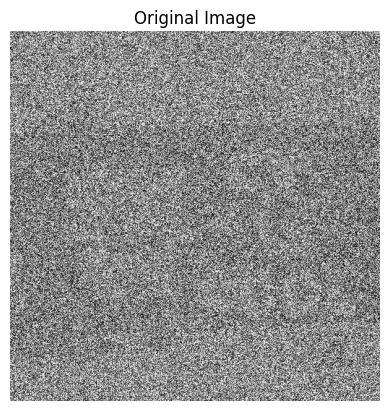

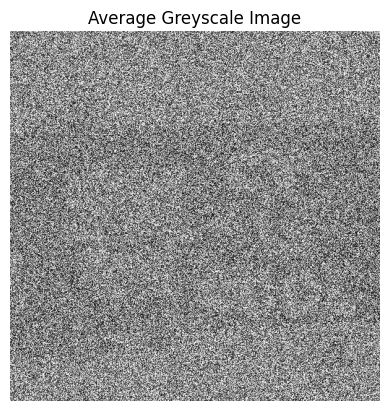

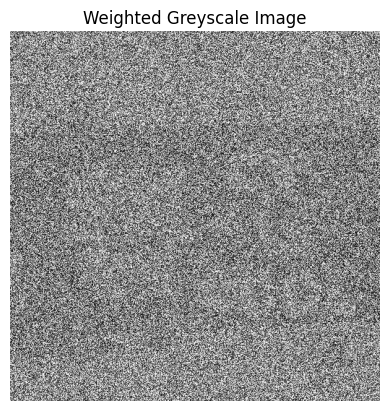

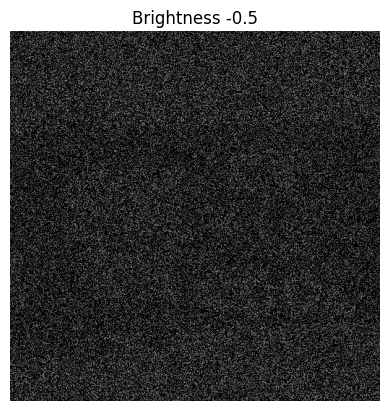

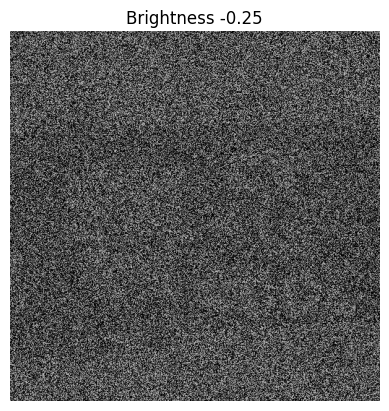

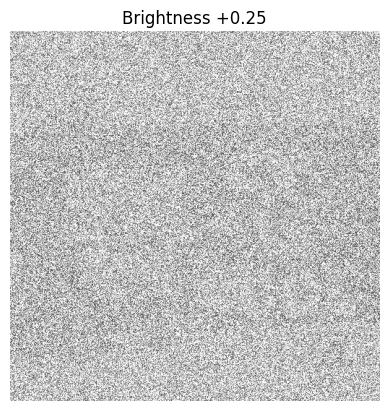

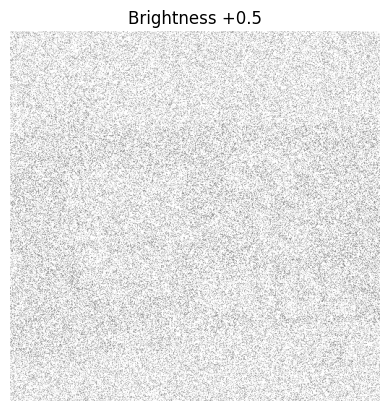

<Figure size 640x480 with 0 Axes>

In [ ]:
'''
MAIN EXECUTION
'''

# Get the image and load it into a modifier class
photometricHiddenImage = cv2.imread("../images/photometric_hidden_image.png")
photometricHiddenImage = cv2.cvtColor(photometricHiddenImage, cv2.COLOR_BGR2RGB)
photometricImageModifier = ImageModifier(photometricHiddenImage)

# Display the image in current form
imageDisplayer = ImageDisplay()
imageDisplayer.showImage(photometricImageModifier.getImage(greyscaleType=GreyscaleType.COLOR), "Original Image")

# Show the image at different greyscales
imageDisplayer.showImage(photometricImageModifier.getImage(greyscaleType=GreyscaleType.AVERAGE), "Average Greyscale Image", doGreyMap=True)
imageDisplayer.showImage(photometricImageModifier.getImage(greyscaleType=GreyscaleType.WEIGHTED), "Weighted Greyscale Image", doGreyMap=True)

# Show the image at different brightness levels
imageDisplayer.showImage(photometricImageModifier.changeImageBrightness(brightnessModifier=-0.5), "Brightness -0.5")
imageDisplayer.showImage(photometricImageModifier.changeImageBrightness(brightnessModifier=-0.25), "Brightness -0.25")
imageDisplayer.showImage(photometricImageModifier.changeImageBrightness(brightnessModifier=0.25), "Brightness +0.25")
imageDisplayer.showImage(photometricImageModifier.changeImageBrightness(brightnessModifier=0.5), "Brightness +0.5")

# Show the image at different contrast levels
imageDisplayer.showImage(photometricImageModifier.changeImageContrast(contrastModifier=0.5), "Contrast 0.5")
imageDisplayer.showImage(photometricImageModifier.changeImageContrast(contrastModifier=1.5), "Contrast 1.5")
imageDisplayer.showImage(photometricImageModifier.changeImageContrast(contrastModifier=2.0), "Contrast 2.0")
imageDisplayer.showImage(photometricImageModifier.changeImageContrast(contrastModifier=3.0), "Contrast 3.0")

	